# <font face="Times New Roman"> <center> Отчет по заданию: 

# <font face="Times New Roman"> <center> Рекомендательная система фильмов на основе данных MovieLens.

#### <font face="Times New Roman"> Выполнил: Таскынов А. Г., группа 317.

<font size=4, face='Times New Roman'> Необходимо было реализовать три метода оценки рейтингов:

* Content based method.
* Neighborhood method.
* Latent factor method.


И сравнить качество каждого из них по метрике MSE по обучающей и тестовой выборкам.

In [17]:
import numpy as np
import pandas as pd
import time
import latent_factor as lf
import preproc as pc
import top_N_similarity as top_sim
from Ridge import RidgeRegression
import matplotlib.pyplot as plt
%matplotlib inline

## <font face="Times New Roman"> Начальная предобработка данных.

In [3]:
users, movies, ratings = pc.read_data()
train, test = pc.train_test_split(ratings)

## <font face="Times New Roman"> Content based метод. 

<font size=4, face="Times New Roman"> В этом методе необходимо построить матрицу объект-признаки, где объектами будет являться пара (пользователь, фильм). Также нужно придумать два новых признака для матрицы. В качестве двух новых признаков были взяты год и количество жанров на один фильм.

Далее рейтинг ищется как линейная комбинация признаков:
$$
\hat r_{u, i} = \sum_{n=1}^{N} \omega_n  f_{u, i}^{n}
$$

Для настройки $\omega$ используется Ridge-регрессия.

Метод реализован в модуле <b>Ridge.py</b>, предобработка данных, построение матрицы объект-признаки в модуле <b> preproc.py </b>

### <font face="Times New Roman"> Предобработка данных.

<font size=4, face="Times New Roman"> Построение матрицы объект-признаки.

In [4]:
X_train, mean_rate_users, mean_rate_movie, F_5 = pc.construct_train(users, movies, train)
X_test = pc.construct_test(users, movies, test, mean_rate_users, mean_rate_movie, F_5)
y_train = train[:, 2]
y_test = test[:, 2]

<font size=4, face="Times New Roman"> Необходимо было подобрать параметр регуляризации $\lambda$ по кросс-валидации:

In [19]:
lambda_param = [1e-5, 0.0001, 0.001, 0.01, 0.1, 0.2, 1.0, 10.0, 100.0, 1000.0, 10000.0]
MSE_train_by_lambda = []
MSE_test_by_lambda = []
for lambda_ in lambda_param:
    clf = RidgeRegression(lambda_=lambda_)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    MSE_test_by_lambda.append((pc.MSE(y_predict, y_test)))
    y_predict = clf.predict(X_train)
    MSE_train_by_lambda.append((pc.MSE(y_predict, y_train)))

In [20]:
print "MSE_train: ",  MSE_train_by_lambda
print "MSE_test: ", MSE_test_by_lambda

MSE_train:  [0.029672838213842007, 0.029672838213842097, 0.029672838213851284, 0.029672838214770139, 0.029672838306419785, 0.029672838583116128, 0.029672847243523749, 0.029673564559978775, 0.029702461303626405, 0.030294652934038151, 0.034439888351614045]
MSE_test:  [0.041764442326928226, 0.041764441017395508, 0.041764427922098786, 0.041764296972300739, 0.041762987793794233, 0.041761533830923576, 0.041749927648508732, 0.041622242995115383, 0.040553664258447815, 0.037029304168281429, 0.038424968435426921]


|lambda|MSE train|MSE test|
|------|---------|--------|
| 0.00001 | 0.029672838 | 0.041764442 |
| 0.0001 | 0.0296728382 | 0.041764441|
| 0.001 | 0.0296728382 | 0.041764427|
| 0.01 | 0.029672838 | 0.0417642969|
|  0.1 | 0.0296728383 | 0.04176298779|
| 0.2  | 0.029672838 | 0.0417615338|
| 1.0  | 0.0296728472 | 0.0417499276 |
| 10.0 | 0.02967356 | 0.04162224|
| 100.0 | 0.029702461| 0.040553664|
|1000.0 | 0.0302946529 | 0.037029304|
|10000.0| 0.03443988835 | 0.038424968 |

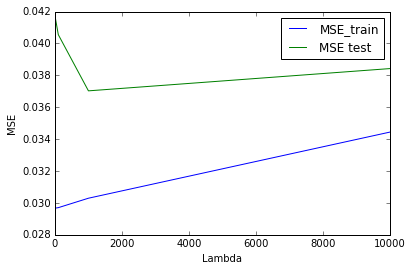

In [21]:
plt.xlabel("Lambda")
plt.ylabel("MSE")
plt.plot(lambda_param, MSE_train_by_lambda,
        lambda_param, MSE_test_by_lambda)
plt.legend(["MSE_train", "MSE test"])

<font size=4, face="Times New Roman"> Как видно, $\lambda = 1000.0$ является оптимальным параметром.

In [124]:
lambda_optimal = lambda_param[np.argmin(MSE_test_by_lambda)]
clf = RidgeRegression(lambda_=lambda_optimal)
start = time.clock()
clf.fit(X_train, y_train)
time_content_based = time.clock() - start
y_predict = clf.predict(X_test)
MSE_test_content_based = pc.MSE(y_predict, y_test)
y_predict = clf.predict(X_train)
MSE_train_content_based = pc.MSE(y_predict, y_train)

In [125]:
print "MSE test: ", MSE_test_content_based
print "MSE train: ", MSE_train_content_based
print "Time to fit: ", time_content_based

MSE test:  0.0370293041683
MSE train:  0.030294652934
Time to fit:  0.892943999999


## <font face="Times New Roman"> Neighborhood метод.

<font size=4, face="Times New Roman"> В данном методе определяется матрица "похожести". Имеются два подхода к построению матрицы: item-oriented, user-oriented.

item-oriented:

$$
sim(i, j) = \frac{\sum_{u \in U} (r_{u, i} - \overline{r_u}) (r_{u, j} - \overline{r_u})}
            {\sqrt{\sum_{u \in U} (r_{u, i} - \overline{r_u})^2} \sqrt{\sum_{u \in U} (r_{u, j} - \overline{r_u})^2}}
$$

, где $U$ - множество пользователей, которые оценили фильмы $i$ и $j$, $\hat r_u$ - средний рейтинг пользователя. 

user-oriented:

$$
sim(u, v) = \frac{\sum_{i \in I} (r_{u, i} - \overline{r_i}) (r_{v, i} - \overline{r_i})}
            {\sqrt{\sum_{i \in I} (r_{u, i} - \overline{r_i})^2} \sqrt{\sum_{i \in I} (r_{v, i} - \overline{r_i})^2}}
$$

, где $I$ - множество фильмов, которые были оценены пользователями $u$ и $v$, $\hat r_i$ - средний рейтинг фильма.

<font size=4, face="Times New Roman"> Item-oriented подход необходимо было реализовать по парадигме MapReduce. Модуль с реализованным методом <b> similarity.py </b>. Сначала считалась вся матрица и записывалась в файл через командную строку. Имя файла, где хранилась матрица: <b> "similarity_train.txt" </b>. Затем из нее выбирались для каждого фильма $N$ самых похожих и по этой "укороченной" матрице делался предикт. Методы запускались локально.

### <font size, face="Times New Roman"> Предобработка данных.

In [55]:
user_movie_train, movie_user_train = lf.dict_user_movie(train)
user_movie_test, movie_user_test = lf.dict_user_movie(test)

In [80]:
time_by_N = []
MSE_train_by_N = []
MSE_test_by_N = []

In [37]:
def read_sim_matrix(filename):
    sim_matrix = open(filename, "r").readlines()
    sim_i_j = np.zeros((3953, 3953))
    for line in sim_matrix:
        l = line.rstrip().split()
        i = int(l[0])
        j = int(l[1])
        sim_i_j[i, j] = float(l[2])
    sim_i_j += sim_i_j.T
    return sim_i_j

<font size=4, face="Times New Roman"> Рейтинги для неизвестных фильмов считаются по формуле: 

$$
\hat r_{u, i} = \frac{\sum_{j: r_{u, j} \neq 0} sim(i, j) r_{u, j}}{\sum_{j: r_{u, j} \neq 0} sim(i, j)}
$$

In [76]:
def predict(sim_i_j, user_movie_train, X):
    y_predict = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        userID = X[i, 0].astype('int')
        movieID = X[i, 1].astype('int')
        moviesID = user_movie_train[userID][0]
        ratings = user_movie_train[userID][2]
        if (sim_i_j[movieID][moviesID].sum() == 0.0):
            y_predict[i] = 0.5
            continue
        y_predict[i] = ((sim_i_j[movieID][moviesID] * ratings).sum()) / (sim_i_j[movieID][moviesID].sum())
    return y_predict

### <font face="Times New Roman"> Similarity matrix.

In [81]:
start = time.clock()
sim_i_j = read_sim_matrix("similarity_matrix.txt")
time_by_N.append(time.clock() - start)
y_predict = predict(sim_i_j, user_movie_train, test)
MSE_test_all_sim = pc.MSE(y_test, y_predict)
y_predict = predict(sim_i_j, user_movie_train, train)
MSE_train_all_sim = pc.MSE(y_train, y_predict)
MSE_train_by_N.append(MSE_train_all_sim)
MSE_test_by_N .append(MSE_test_all_sim)

In [83]:
print MSE_train_by_N
print MSE_test_by_N
print time_by_N

[0.025420330922173481]
[0.035106683475658318]
[3.901177999999959]


<font size=4, face="Times New Roman"> Как мы видим, $MSE = 0.0351$ на тесте и $0.0254$ на обучении, что означает о присутствии незначительного переобучения. Далее будут предоставлены результаты при сохранении не всей матрицы, а первых $N$ схожих к данному фильму.

### <font face="Times New Roman"> Max similar = 1.

In [84]:
reload(top_sim)

<module 'top_N_similarity' from 'top_N_similarity.py'>

In [85]:
sim_i_j = np.zeros((3953, 3953))
mr_job = top_sim.MRTop_N_Similarity(args=["similarity_train.txt"])
with mr_job.make_runner() as runner:
    start = time.clock()
    runner.run()
    time_by_N.append(time.clock() - start)
    for line in runner.stream_output():
        key, value = mr_job.parse_output_line(line)
        i = int(key[0])
        j = int(key[1])
        sim_i_j[i, j] = float(value)
sim_i_j += sim_i_j.T
y_predict = predict(sim_i_j, user_movie_train, test)
MSE_test_by_N .append(pc.MSE(y_test, y_predict))
y_predict = predict(sim_i_j, user_movie_train, train)
MSE_train_by_N.append(pc.MSE(y_train, y_predict))

In [86]:
print MSE_train_by_N
print MSE_test_by_N
print time_by_N

[0.025420330922173481, 0.098532546495085777]
[0.035106683475658318, 0.087219879080059071]
[3.901177999999959, 33.70286199999998]


### <font face="Times New Roman"> Max similar = 5.

In [87]:
reload(top_sim)
sim_i_j = np.zeros((3953, 3953))
mr_job = top_sim.MRTop_N_Similarity(args=["similarity_train.txt"])
with mr_job.make_runner() as runner:
    start = time.clock()
    runner.run()
    time_by_N.append(time.clock() - start)
    for line in runner.stream_output():
        key, value = mr_job.parse_output_line(line)
        i = int(key[0])
        j = int(key[1])
        sim_i_j[i, j] = float(value)
sim_i_j += sim_i_j.T
y_predict = predict(sim_i_j, user_movie_train, test)
MSE_test_by_N .append(pc.MSE(y_test, y_predict))
y_predict = predict(sim_i_j, user_movie_train, train)
MSE_train_by_N.append(pc.MSE(y_train, y_predict))
print MSE_train_by_N
print MSE_test_by_N
print time_by_N

[0.025420330922173481, 0.098532546495085777, 0.096217939414928719]
[0.035106683475658318, 0.087219879080059071, 0.087211597648742756]
[3.901177999999959, 33.70286199999998, 35.95260999999999]


### <font face="Times New Roman"> Max similar = 10.

In [88]:
reload(top_sim)
sim_i_j = np.zeros((3953, 3953))
mr_job = top_sim.MRTop_N_Similarity(args=["similarity_train.txt"])
with mr_job.make_runner() as runner:
    start = time.clock()
    runner.run()
    time_by_N.append(time.clock() - start)
    for line in runner.stream_output():
        key, value = mr_job.parse_output_line(line)
        i = int(key[0])
        j = int(key[1])
        sim_i_j[i, j] = float(value)
sim_i_j += sim_i_j.T
y_predict = predict(sim_i_j, user_movie_train, test)
MSE_test_by_N .append(pc.MSE(y_test, y_predict))
y_predict = predict(sim_i_j, user_movie_train, train)
MSE_train_by_N.append(pc.MSE(y_train, y_predict))
print MSE_train_by_N
print MSE_test_by_N
print time_by_N

[0.025420330922173481, 0.098532546495085777, 0.096217939414928719, 0.093852562771719036]
[0.035106683475658318, 0.087219879080059071, 0.087211597648742756, 0.086664611473800349]
[3.901177999999959, 33.70286199999998, 35.95260999999999, 36.490665999999976]


### <font face="Times New Roman"> Max similar = 50.

In [90]:
reload(top_sim)
sim_i_j = np.zeros((3953, 3953))
mr_job = top_sim.MRTop_N_Similarity(args=["similarity_train.txt"])
with mr_job.make_runner() as runner:
    start = time.clock()
    runner.run()
    time_by_N.append(time.clock() - start)
    for line in runner.stream_output():
        key, value = mr_job.parse_output_line(line)
        i = int(key[0])
        j = int(key[1])
        sim_i_j[i, j] = float(value)
sim_i_j += sim_i_j.T
y_predict = predict(sim_i_j, user_movie_train, test)
MSE_test_by_N .append(pc.MSE(y_test, y_predict))
y_predict = predict(sim_i_j, user_movie_train, train)
MSE_train_by_N.append(pc.MSE(y_train, y_predict))
print MSE_train_by_N
print MSE_test_by_N
print time_by_N

[0.025420330922173481, 0.098532546495085777, 0.096217939414928719, 0.093852562771719036, 0.08159757829779811]
[0.035106683475658318, 0.087219879080059071, 0.087211597648742756, 0.086664611473800349, 0.083141115553911793]
[3.901177999999959, 33.70286199999998, 35.95260999999999, 36.490665999999976, 36.90924000000001]


### <font face="Times New Roman"> Max similar = 100.

In [91]:
reload(top_sim)
sim_i_j = np.zeros((3953, 3953))
mr_job = top_sim.MRTop_N_Similarity(args=["similarity_train.txt"])
with mr_job.make_runner() as runner:
    start = time.clock()
    runner.run()
    time_by_N.append(time.clock() - start)
    for line in runner.stream_output():
        key, value = mr_job.parse_output_line(line)
        i = int(key[0])
        j = int(key[1])
        sim_i_j[i, j] = float(value)
sim_i_j += sim_i_j.T
y_predict = predict(sim_i_j, user_movie_train, test)
MSE_test_by_N .append(pc.MSE(y_test, y_predict))
y_predict = predict(sim_i_j, user_movie_train, train)
MSE_train_by_N.append(pc.MSE(y_train, y_predict))
print MSE_train_by_N
print MSE_test_by_N
print time_by_N

[0.025420330922173481, 0.098532546495085777, 0.096217939414928719, 0.093852562771719036, 0.08159757829779811, 0.063122845608971967]
[0.035106683475658318, 0.087219879080059071, 0.087211597648742756, 0.086664611473800349, 0.083141115553911793, 0.073728817097900648]
[3.901177999999959, 33.70286199999998, 35.95260999999999, 36.490665999999976, 36.90924000000001, 38.53158000000002]


### <font face="Times New Roman"> Max similar = 500.

In [92]:
reload(top_sim)
sim_i_j = np.zeros((3953, 3953))
mr_job = top_sim.MRTop_N_Similarity(args=["similarity_train.txt"])
with mr_job.make_runner() as runner:
    start = time.clock()
    runner.run()
    time_by_N.append(time.clock() - start)
    for line in runner.stream_output():
        key, value = mr_job.parse_output_line(line)
        i = int(key[0])
        j = int(key[1])
        sim_i_j[i, j] = float(value)
sim_i_j += sim_i_j.T
y_predict = predict(sim_i_j, user_movie_train, test)
MSE_test_by_N .append(pc.MSE(y_test, y_predict))
y_predict = predict(sim_i_j, user_movie_train, train)
MSE_train_by_N.append(pc.MSE(y_train, y_predict))
print MSE_train_by_N
print MSE_test_by_N
print time_by_N

[0.025420330922173481, 0.098532546495085777, 0.096217939414928719, 0.093852562771719036, 0.08159757829779811, 0.063122845608971967, 0.023827519211171731]
[0.035106683475658318, 0.087219879080059071, 0.087211597648742756, 0.086664611473800349, 0.083141115553911793, 0.073728817097900648, 0.036857677197153847]
[3.901177999999959, 33.70286199999998, 35.95260999999999, 36.490665999999976, 36.90924000000001, 38.53158000000002, 44.13665100000003]


### <font face="Times New Roman"> Max similar = 1000.

In [93]:
reload(top_sim)
sim_i_j = np.zeros((3953, 3953))
mr_job = top_sim.MRTop_N_Similarity(args=["similarity_train.txt"])
with mr_job.make_runner() as runner:
    start = time.clock()
    runner.run()
    time_by_N.append(time.clock() - start)
    for line in runner.stream_output():
        key, value = mr_job.parse_output_line(line)
        i = int(key[0])
        j = int(key[1])
        sim_i_j[i, j] = float(value)
sim_i_j += sim_i_j.T
y_predict = predict(sim_i_j, user_movie_train, test)
MSE_test_by_N .append(pc.MSE(y_test, y_predict))
y_predict = predict(sim_i_j, user_movie_train, train)
MSE_train_by_N.append(pc.MSE(y_train, y_predict))
print MSE_train_by_N
print MSE_test_by_N
print time_by_N

[0.025420330922173481, 0.098532546495085777, 0.096217939414928719, 0.093852562771719036, 0.08159757829779811, 0.063122845608971967, 0.023827519211171731, 0.025015974279679744]
[0.035106683475658318, 0.087219879080059071, 0.087211597648742756, 0.086664611473800349, 0.083141115553911793, 0.073728817097900648, 0.036857677197153847, 0.035157638015371834]
[3.901177999999959, 33.70286199999998, 35.95260999999999, 36.490665999999976, 36.90924000000001, 38.53158000000002, 44.13665100000003, 47.43408099999999]


### <font face="Times New Roman"> Max similar = 2000.

In [94]:
reload(top_sim)
sim_i_j = np.zeros((3953, 3953))
mr_job = top_sim.MRTop_N_Similarity(args=["similarity_train.txt"])
with mr_job.make_runner() as runner:
    start = time.clock()
    runner.run()
    time_by_N.append(time.clock() - start)
    for line in runner.stream_output():
        key, value = mr_job.parse_output_line(line)
        i = int(key[0])
        j = int(key[1])
        sim_i_j[i, j] = float(value)
sim_i_j += sim_i_j.T
y_predict = predict(sim_i_j, user_movie_train, test)
MSE_test_by_N .append(pc.MSE(y_test, y_predict))
y_predict = predict(sim_i_j, user_movie_train, train)
MSE_train_by_N.append(pc.MSE(y_train, y_predict))
print MSE_train_by_N
print MSE_test_by_N
print time_by_N

[0.025420330922173481, 0.098532546495085777, 0.096217939414928719, 0.093852562771719036, 0.08159757829779811, 0.063122845608971967, 0.023827519211171731, 0.025015974279679744, 0.025394110877700611]
[0.035106683475658318, 0.087219879080059071, 0.087211597648742756, 0.086664611473800349, 0.083141115553911793, 0.073728817097900648, 0.036857677197153847, 0.035157638015371834, 0.035146829475759915]
[3.901177999999959, 33.70286199999998, 35.95260999999999, 36.490665999999976, 36.90924000000001, 38.53158000000002, 44.13665100000003, 47.43408099999999, 51.202174000000014]


<center> <font size=4, face="Times New Roman"> Таблица, показывающая качество метода при разных $N$:

|Max Similar ($N$)|MSE train|MSE test| Time|
|------|---------|--------|-------|
| 1 | 0.098532546 | 0.087219879 | 33.70286|
| 5 | 0.096217939 | 0.0872115976|  35.9526|
| 10 | 0.09385256 | 0.08666461147| 36.49066|
| 50 | 0.081597578 | 0.08314111| 36.90924|
|  100 | 0.063122845 | 0.073728817| 38.53158|
| 500  | 0.023827519 | 0.036857677| 44.136651|
| 1000  | 0.025015974 | 0.035157638 | 47.43408|
| 2000 | 0.02539411 | 0.035146829| 51.202174|

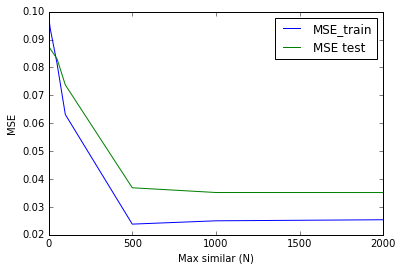

In [95]:
plt.xlabel("Max similar (N)")
plt.ylabel("MSE")
N_param = [1, 5, 10, 50, 100, 500, 1000, 2000]
plt.plot(N_param, MSE_train_by_N[1: ],
        N_param, MSE_test_by_N[1: ])
plt.legend(["MSE_train", "MSE test"])

<font size=4, face="Times New Roman"> Как мы видим увеличение числа $N$ ($N$ - максимальное количество похожих фильмов) дает уменьшение MSE, однако после 1000 можно хранить всю матрицу и делать по ней предикт.

## <font face="Times New Roman"> Latent Factor метод.

<font size=4, face="Times New Roman"> Неизвестные рейтинги в этом методе ищутся как:
$$
\hat r_{u, i} = p^{T}_u q_i
$$
, где $p, q \in \mathbb{R}^K$.

Оптимизируется функционал:
$$
\sum_{(u, i, r_{u, i})} ((r_{u, i} - p^{T}_u q_i)^2 + \lambda_p p_u^T p_u + \lambda_q q_i^T q_i)
$$

$P$ (матрица из $p_u$) и $Q$ (матрица из $q_i$) ищутся итерационно. Сначала по зафиксированной матрице $P$ считается $Q$, затем наоборот.  Подматрицей $Q[u] \in \mathbb{R}^{n_u \times K}$ обозначается подматрица матрицы $Q$ только для товаров, оцененных пользователем $u$, $n_u$ - количество таких товаров. $P[i] \in \mathbb{R}^{n_i \times K}$ - подматрица матрицы $P$ только для таких пользователей, которые оценили товар $i$, $n_i$ - колиество таких пользователей. Соответственно формулы для перерасчета:

$$
A_u = Q[u]^{T} Q[u]
$$

$$
d_u = Q[u]^{T} r_u
$$

$$
p_u = (\lambda_p n_u  I + A_u)^{-1} d_u
$$

$$
A_i = P[i]^{T} P[i]
$$

$$
d_i = Q[i]^{T} r_i
$$

$$
q_i = (\lambda_q n_i  I + A_i)^{-1} d_i
$$

Для тестирования реализации предлагалось использовать значения $\lambda_p = 0.2$, $\lambda_q = 0.001$, $N = 20$, $K = 10$. Эти значения параметров были использованы как значения по умолчанию для метода. Реализация метода и необходимая предобработка данных хранится в файле <b>latent_factor.py</b>.

In [122]:
clf = lf.LatentFactor()
clf.fit(user_movie_train, movie_user_train, y_train)
y_predict = clf.predict(test, user_movie_test, movie_user_test)
print pc.MSE(y_test, y_predict)

0.0304936278917


<font size=4, face="Times New Roman"> Как видно, метод реализован правильно, судя по значению MSE на тестовой выборке.

<font size=4, face="Times New Roman"> Далее будут приведены результаты экспериментов по выбору оптимальных параметров $\lambda_p$, количества итераций, $\lambda_q$, $K$ - размерности пространства латентных признаков.

### <font face="Times New Roman"> Кросс-валидация по числу итераций.

In [97]:
max_iter_values = [10, 20, 30, 40]
MSE_max_iter = []
time_max_iter = []
for max_iter in max_iter_values:
    clf = lf.LatentFactor(max_iter=max_iter)
    start = time.clock()
    clf.fit(user_movie_train, movie_user_train, y_train)
    time_max_iter.append(time.clock() - start)
    y_predict = clf.predict(test, user_movie_test, movie_user_test)
    MSE_max_iter.append(pc.MSE(y_test, y_predict))

In [100]:
print "MSE: ", MSE_max_iter
print "Time: ", time_max_iter

MSE:  [0.03111135354969366, 0.030533037673092248, 0.03042098277995722, 0.03037374450620892]
Time:  [45.95167599999991, 92.72957199999996, 138.58841800000005, 186.23559999999998]


<font size=4, face="Times New Roman"> Как видно, чем больше итераций, тем лучше качество, однако и увеличивается время. Но так как улучшение не такое сильное, то число итераций равное 30 можно будет считать оптимальным.

### <font face="Times New Roman"> Кросс-валидация по $\lambda_p$.

In [101]:
lambda_p_values = [0.001, 0.01, 0.1, 0.2, 0.5, 1.0]
MSE_lambda_p = []
for lambda_p in lambda_p_values:
    clf = lf.LatentFactor(lambda_p=lambda_p, max_iter=30)
    clf.fit(user_movie_train, movie_user_train, y_train)
    y_predict = clf.predict(test, user_movie_test, movie_user_test)
    MSE_lambda_p.append(pc.MSE(y_test, y_predict))

In [102]:
print "MSE: ", MSE_lambda_p

MSE:  [0.036124742252994529, 0.033225745413776549, 0.030731433434637287, 0.030400597620690264, 0.030856268230983704, 0.032267940252331227]


<font size=4, face="Times New Roman"> Как мы видим, параметр по умолчанию $\lambda_p = 0.2$ является оптимальным.

### <font face="Times New Roman"> Кросс-валидация по $\lambda_q$.

In [103]:
lambda_q_values = [1e-5, 0.0001, 0.001, 0.01, 0.1, 1.0]
MSE_lambda_q = []
for lambda_q in lambda_q_values:
    clf = lf.LatentFactor(lambda_q=lambda_q, max_iter=30)
    clf.fit(user_movie_train, movie_user_train, y_train)
    y_predict = clf.predict(test, user_movie_test, movie_user_test)
    MSE_lambda_q.append(pc.MSE(y_test, y_predict))

In [104]:
print "MSE: ", MSE_lambda_q

MSE:  [0.035245526282512769, 0.032350897561427103, 0.030454414937511446, 0.034232688404786084, 0.050428603688532081, 0.21298870465359157]


<font face="Times New Roman", size=4> Как мы видим, $\lambda_q = 0.001$ является оптимальным параметром.

### <font face="Times New Roman"> Кросс-валидация по размерности пространства латентных признаков .

<font face="Times New Roman", size=4> Необходимо посмотреть на качество метода в зависимости от размерности пространства латентных признаков ($K$). Сравнить по времени работы и по качеству на обучающей и тестовой выборках и узнать ведет ли к переобучению увеличение $K$.

In [105]:
K_values = [1, 5, 10, 20, 50, 100, 200, 300]
MSE_train_K = []
MSE_test_K = []
time_K = []
for K in K_values:
    clf = lf.LatentFactor(K=K, max_iter=30)
    start = time.clock()
    clf.fit(user_movie_train, movie_user_train, y_train)
    time_K.append(time.clock() - start)
    y_predict = clf.predict(test, user_movie_test, movie_user_test)
    MSE_test_K.append(pc.MSE(y_test, y_predict))
    y_predict = clf.predict(train, user_movie_train, movie_user_train)
    MSE_train_K.append(pc.MSE(y_train, y_predict))

In [106]:
print "MSE train: ", MSE_train_K
print "MSE test: ", MSE_test_K
print "Time to fit: ", time_K

MSE train:  [0.032664636502578601, 0.026923681333174992, 0.024295028394565446, 0.021725036313804021, 0.018540666315586363, 0.016995127421537658, 0.016592519715523498, 0.016562128521574206]
MSE test:  [0.034382378359892551, 0.030942236303918128, 0.03039341205307584, 0.030408300733008358, 0.030399391032272089, 0.030278040990292486, 0.03019671528096126, 0.030187518591343922]
Time to fit:  [17.43271500000037, 70.13100600000007, 137.40568699999994, 175.86705799999982, 309.8233140000002, 611.5503680000002, 1782.5636429999995, 3795.2492699999993]


|$K$|MSE train|MSE test| Time|
|------|---------|--------|-------|
| 1 | 0.0326646 | 0.034382378 | 17.432715|
| 5 | 0.02692368 | 0.030942236|  70.131|
| 10 | 0.024295 | 0.030393412| 137.4|
| 20 | 0.021725 | 0.0304083| 175.867|
|  50 | 0.018540666 | 0.03039939| 309.823314|
| 100  | 0.016995 | 0.03027804| 611.55|
| 200  | 0.0165925 | 0.030196715 | 1782.56364|
| 300 | 0.0165621 | 0.03018751859| 3795.249|

<font size=4, face="Times New Roman"> Как видно из таблицы увеличение $K$ ведет к небольшому переобучению. MSE при $K=10$ можно считать оптимальным по времени и по качеству на обучении и тесте.

## <font face="Times New Roman"> Сравнение трёх методов по лучшим параметрам.

|Method|MSE train|MSE test| Time to fit|
|------|---------|--------|-------|
| Content based | 0.03029 |0.037029 | 0.832391|
| Neighborhood | 0.02542 | 0.0351|  3.9|
| Latent factor |  0.024295 | 0.030393412| 137.4|

<font size=4, face="Times New Roman"> Как видно, самым лучшим методом является Latent factor, однако он также долго работает по времени.